In [204]:
import spacy
spacy_nlp = spacy.load("en_core_web_sm")
from spacy.lang.en.stop_words import STOP_WORDS
import utility_functions as utils
import importlib
import pandas as pd
import librosa
import numpy as np
import torch
from tqdm.auto import tqdm
from transformers import DistilBertTokenizer, DistilBertModel
from sklearn.model_selection import GridSearchCV, StratifiedKFold, cross_val_predict, cross_val_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, VotingClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold, cross_val_predict
from sklearn.metrics import classification_report, make_scorer, f1_score
from sklearn.preprocessing import StandardScaler
import pickle
from sklearn.preprocessing import LabelEncoder
import joblib

importlib.reload(utils)

custom_stop_words = list(STOP_WORDS)  # Existing stop words
custom_stop_words.extend(["ll", "ve", "'em", "em", "ho", "fo", "ah", "de"])  # Tokens which doesn't really make sense to have them.

best_model_settings = {
    'lyrics_only': {
        'random_forest':  {'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 200},
        'gradient_boosting': {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100},
        'adaboost': {'learning_rate': 0.1, 'n_estimators': 100}
    },
    'hardness_audio_features': {
        'random_forest': {'max_depth': 10, 'min_samples_split': 5, 'n_estimators': 200},
        'gradient_boosting': {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100},
        'adaboost': {'learning_rate': 0.01, 'n_estimators': 100}
    },
    'hardness_and_lyrics_and_topic_model': {
        'random_forest': {'max_depth': 20, 'min_samples_split': 5, 'n_estimators': 200},
        'gradient_boosting': {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200},
        'adaboost': {'learning_rate': 1.0, 'n_estimators': 100}
    },
    'audio_and_lyrics_and_emotions': {
        'random_forest': {'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 100},
        'gradient_boosting': {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100},
        'adaboost': {'learning_rate': 1.0, 'n_estimators': 50}
    },
    'audio_and_lyrics_and_emotions_and_locations': {
        'random_forest': {'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 200},
        'gradient_boosting': {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200},
        'adaboost': {'learning_rate': 1.0, 'n_estimators': 50}
    }
}

In [113]:
df = pd.read_excel('/Users/borosabel/Documents/Uni/Thesis/PopMIR/Data/Excel/baseline_data.xlsx', engine='openpyxl')

In [114]:
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
model = DistilBertModel.from_pretrained('distilbert-base-uncased')

def get_lyrics_embeddings(lyrics):
    max_length = 512
    tokens = tokenizer.tokenize(lyrics)
    chunks = [tokens[i:i + max_length] for i in range(0, len(tokens), max_length)]
    all_embeddings = []
    for chunk in chunks:
        inputs = tokenizer.convert_tokens_to_ids(chunk)
        inputs = tokenizer.prepare_for_model(inputs, max_length=max_length, padding='max_length', truncation=True, return_tensors='pt')
        with torch.no_grad():
            outputs = model(**inputs)
            embeddings = outputs.last_hidden_state.mean(dim=1)
            all_embeddings.append(embeddings)
    aggregated_embeddings = torch.mean(torch.stack(all_embeddings), dim=0)
    return aggregated_embeddings.numpy()

def get_audio_features(audio_path):
    y, sr = librosa.load(audio_path, sr=None)
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
    chroma = librosa.feature.chroma_stft(y=y, sr=sr)
    contrast = librosa.feature.spectral_contrast(y=y, sr=sr)
    features = np.concatenate([mfcc.mean(axis=1), chroma.mean(axis=1), contrast.mean(axis=1)])
    return features

In [123]:
def run_ensemble_model(X, y, datatype, best_settings=None, save=False):
    if best_settings is None:
        param_grid_rf = {
            'n_estimators': [100, 200],
            'max_depth': [None, 10, 20],
            'min_samples_split': [2, 5]
        }

        param_grid_gb = {
            'n_estimators': [100, 200],
            'learning_rate': [0.01, 0.1],
            'max_depth': [3, 5]
        }

        param_grid_ada = {
            'n_estimators': [50, 100],
            'learning_rate': [0.01, 0.1, 1.0]
        }

        # Define classifiers
        random_forest = RandomForestClassifier(random_state=42)
        gradient_boosting = GradientBoostingClassifier(random_state=42)
        ada_boost = AdaBoostClassifier(random_state=42)

        # Perform grid search for each classifier
        scorer = make_scorer(f1_score, average='weighted')

        grid_search_rf = GridSearchCV(estimator=random_forest, param_grid=param_grid_rf, scoring=scorer, cv=StratifiedKFold(n_splits=5), n_jobs=-1)
        grid_search_gb = GridSearchCV(estimator=gradient_boosting, param_grid=param_grid_gb, scoring=scorer, cv=StratifiedKFold(n_splits=5), n_jobs=-1)
        grid_search_ada = GridSearchCV(estimator=ada_boost, param_grid=param_grid_ada, scoring=scorer, cv=StratifiedKFold(n_splits=5), n_jobs=-1)

        # Fit grid search
        grid_search_rf.fit(X, y)
        grid_search_gb.fit(X, y)
        grid_search_ada.fit(X, y)

        # Print best parameters for each model
        print(f"Best parameters for Random Forest: {grid_search_rf.best_params_}")
        print(f"Best parameters for Gradient Boosting: {grid_search_gb.best_params_}")
        print(f"Best parameters for AdaBoost: {grid_search_ada.best_params_}")

        # Get best estimators
        best_rf = grid_search_rf.best_estimator_
        best_gb = grid_search_gb.best_estimator_
        best_ada = grid_search_ada.best_estimator_
    else:
        # Load the best settings if provided
        best_rf = RandomForestClassifier(random_state=42, **best_settings[datatype]['random_forest'])
        best_gb = GradientBoostingClassifier(random_state=42, **best_settings[datatype]['gradient_boosting'])
        best_ada = AdaBoostClassifier(random_state=42, **best_settings[datatype]['adaboost'])

    if save:
        joblib.dump(best_rf, f'best_random_forest_{datatype}.pkl')
        joblib.dump(best_gb, f'best_gradient_boosting_{datatype}.pkl')
        joblib.dump(best_ada, f'best_adaboost_{datatype}.pkl')

    # Define an ensemble of the best estimators
    voting_clf = VotingClassifier(estimators=[
        ('rf', best_rf),
        ('gb', best_gb),
        ('ada', best_ada)
    ], voting='soft')

    # List of classifiers to evaluate
    classifiers = {
        'Random Forest': best_rf,
        'Gradient Boosting': best_gb,
        'AdaBoost': best_ada,
        'Voting Classifier': voting_clf
    }

    # Evaluate each classifier using cross-validation and collect metrics
    skf = StratifiedKFold(n_splits=5)
    metrics = {'accuracy': {}, 'precision': {}, 'recall': {}, 'f1': {}}

    for name, clf in classifiers.items():
        accuracy = cross_val_score(clf, X, y, cv=skf, scoring='accuracy')
        precision = cross_val_score(clf, X, y, cv=skf, scoring='precision_weighted')
        recall = cross_val_score(clf, X, y, cv=skf, scoring='recall_weighted')
        f1 = cross_val_score(clf, X, y, cv=skf, scoring='f1_weighted')

        metrics['accuracy'][name] = accuracy
        metrics['precision'][name] = precision
        metrics['recall'][name] = recall
        metrics['f1'][name] = f1

        y_pred = cross_val_predict(clf, X, y, cv=skf)
        report = classification_report(y, y_pred, target_names=label_encoder.classes_)
        print(f"Classifier: {name}")
        print(report)
        print("\n")

    return metrics  # Optionally return metrics if needed

<b>Compute features</b>

In [115]:
tqdm.pandas(desc="Extracting lyrics embeddings")
df['Lyrics'] = df['Lyrics'].apply(utils.cleanup)
df['lyrics_embeddings'] = df['Lyrics'].progress_apply(get_lyrics_embeddings)

Extracting lyrics embeddings:   0%|          | 0/1368 [00:00<?, ?it/s]

In [6]:
# tqdm.pandas(desc="Extracting audio features")
# df['audio_features'] = df['Path'].progress_apply(get_audio_features)

Extracting audio features:   0%|          | 0/1368 [00:00<?, ?it/s]

In [117]:
# # Save to a pickle file
# with open('dataframe.pkl', 'wb') as file:
#     pickle.dump(df, file)

In [118]:
with open('dataframe.pkl', 'rb') as file:
    df = pickle.load(file)

<b>Lyrics only</b>

In [125]:
lyrics_features = np.vstack(df['lyrics_embeddings'].values)

# Normalize lyrics embeddings
scaler_lyrics = StandardScaler()
X_lyrics = scaler_lyrics.fit_transform(lyrics_features)

# Encode labels
label_encoder = LabelEncoder()
df['coast_label'] = label_encoder.fit_transform(df['Coast'])
y_lyrics = df['coast_label'].values

only_lyrics_metrics = run_ensemble_model(X_lyrics, y_lyrics, datatype='lyrics_only', best_settings=best_model_settings, save=True)

Classifier: Random Forest
              precision    recall  f1-score   support

  east_coast       0.66      0.72      0.69       702
  west_coast       0.67      0.61      0.64       666

    accuracy                           0.66      1368
   macro avg       0.67      0.66      0.66      1368
weighted avg       0.66      0.66      0.66      1368
Classifier: Gradient Boosting
              precision    recall  f1-score   support

  east_coast       0.67      0.70      0.68       702
  west_coast       0.67      0.65      0.66       666

    accuracy                           0.67      1368
   macro avg       0.67      0.67      0.67      1368
weighted avg       0.67      0.67      0.67      1368


Classifier: AdaBoost
              precision    recall  f1-score   support

  east_coast       0.66      0.70      0.68       702
  west_coast       0.66      0.62      0.64       666

    accuracy                           0.66      1368
   macro avg       0.66      0.66      0.66      13

<b>Hardness audio</b>

In [126]:
df = pd.read_excel('/Users/borosabel/Documents/Uni/Thesis/PopMIR/Data/Excel/baseline_data_w_topics_w_features.xlsx', engine='openpyxl')

file_path = '/Users/borosabel/Documents/Uni/Thesis/PopMIR/Code/Lyrics/indexes.txt'

# Read the file and convert each line to an integer
with open(file_path, 'r') as file:
    indices = [int(line.strip()) for line in file]
    
df = df.iloc[indices]

In [127]:
columns_to_remove = ['Artist', 'Album', 'Song', 'Release Year', 'Tempo2', 'Duration (s)', 'Sample Rate (Hz)', 'Path', 'Lyrics', 'Coast']
label_column = 'Coast'
feature_columns = [item for item in list(df.columns) if item not in columns_to_remove]

In [128]:
features = df[feature_columns].values

In [129]:
label_encoder = LabelEncoder()
df['coast_label'] = label_encoder.fit_transform(df['Coast'])
y_hardness = df['coast_label'].values

# Normalize the features
scaler = StandardScaler()
X_hardness = scaler.fit_transform(features)

In [130]:
hardness_audio_features_metrics = run_ensemble_model(X_hardness, y_hardness, datatype='hardness_audio_features', best_settings=best_model_settings, save=True)

Classifier: Random Forest
              precision    recall  f1-score   support

  east_coast       0.57      0.53      0.55       698
  west_coast       0.54      0.57      0.56       662

    accuracy                           0.55      1360
   macro avg       0.55      0.55      0.55      1360
weighted avg       0.55      0.55      0.55      1360


Classifier: Gradient Boosting
              precision    recall  f1-score   support

  east_coast       0.63      0.69      0.66       698
  west_coast       0.63      0.57      0.60       662

    accuracy                           0.63      1360
   macro avg       0.63      0.63      0.63      1360
weighted avg       0.63      0.63      0.63      1360


Classifier: AdaBoost
              precision    recall  f1-score   support

  east_coast       0.62      0.66      0.64       698
  west_coast       0.62      0.57      0.59       662

    accuracy                           0.62      1360
   macro avg       0.62      0.62      0.62      

<b>Hardness Features + Lyrics embeddings</b>

In [133]:
df = pd.read_excel('/Users/borosabel/Documents/Uni/Thesis/PopMIR/Data/Excel/baseline_data_w_topics_w_features.xlsx', engine='openpyxl')

indices_file_path = '/Users/borosabel/Documents/Uni/Thesis/PopMIR/Code/Lyrics/indexes.txt'

# Read the file and convert each line to an integer
with open(file_path, 'r') as file:
    indices = [int(line.strip()) for line in file]

df = df.iloc[indices]

columns_to_remove = ['Artist', 'Album', 'Song', 'Release Year', 'Tempo2', 'Duration (s)', 'Sample Rate (Hz)', 'Path', 'Lyrics', 'Coast']
label_column = 'Coast'
feature_columns = [item for item in list(df.columns) if item not in columns_to_remove]

In [134]:
# Load the lyrics embeddings datafarme
with open('dataframe.pkl', 'rb') as file:
    df_lyrics_embeddings = pickle.load(file)

def flatten_embeddings(embeddings):
    return np.array(embeddings).flatten()

df['lyrics_embeddings'] = df_lyrics_embeddings['lyrics_embeddings']
df['lyrics_embeddings'] = df['lyrics_embeddings'].apply(flatten_embeddings)

In [135]:
lyrics_features = np.vstack(df['lyrics_embeddings'].values)
scaler_lyrics = StandardScaler()
lyrics_features_normalized = scaler_lyrics.fit_transform(lyrics_features)

In [136]:
features = df[feature_columns].values

In [137]:
combined_features = np.hstack([features, lyrics_features_normalized])
scaler_combined = StandardScaler()
X_hardness_and_lyrics = scaler_combined.fit_transform(combined_features)

In [138]:
label_encoder = LabelEncoder()
df['coast_label'] = label_encoder.fit_transform(df['Coast'])
y_hardness_and_lyrics = df['coast_label'].values

In [139]:
hardness_and_lyrics_metrics = run_ensemble_model(X_hardness_and_lyrics, y_hardness_and_lyrics, datatype='hardness_and_lyrics_and_topic_model', best_settings=best_model_settings, save=True)

Classifier: Random Forest
              precision    recall  f1-score   support

  east_coast       0.66      0.70      0.68       698
  west_coast       0.66      0.61      0.64       662

    accuracy                           0.66      1360
   macro avg       0.66      0.66      0.66      1360
weighted avg       0.66      0.66      0.66      1360


Classifier: Gradient Boosting
              precision    recall  f1-score   support

  east_coast       0.69      0.70      0.70       698
  west_coast       0.68      0.67      0.67       662

    accuracy                           0.69      1360
   macro avg       0.69      0.68      0.68      1360
weighted avg       0.69      0.69      0.69      1360


Classifier: AdaBoost
              precision    recall  f1-score   support

  east_coast       0.68      0.66      0.67       698
  west_coast       0.65      0.67      0.66       662

    accuracy                           0.67      1360
   macro avg       0.67      0.67      0.67      

{'accuracy': {'Random Forest': array([0.69852941, 0.70588235, 0.69117647, 0.5625    , 0.63602941]),
  'Gradient Boosting': array([0.73897059, 0.71323529, 0.67647059, 0.64338235, 0.65441176]),
  'AdaBoost': array([0.69852941, 0.69117647, 0.66176471, 0.65808824, 0.625     ]),
  'Voting Classifier': array([0.74264706, 0.71323529, 0.68014706, 0.64705882, 0.65073529])},
 'precision': {'Random Forest': array([0.70437466, 0.7216814 , 0.69107435, 0.56212432, 0.64584989]),
  'Gradient Boosting': array([0.74266793, 0.73811939, 0.67723403, 0.64512751, 0.65731739]),
  'AdaBoost': array([0.69844005, 0.71399594, 0.66219723, 0.65882192, 0.62506821]),
  'Voting Classifier': array([0.74691439, 0.74065564, 0.68073645, 0.64864222, 0.65385761])},
 'recall': {'Random Forest': array([0.69852941, 0.70588235, 0.69117647, 0.5625    , 0.63602941]),
  'Gradient Boosting': array([0.73897059, 0.71323529, 0.67647059, 0.64338235, 0.65441176]),
  'AdaBoost': array([0.69852941, 0.69117647, 0.66176471, 0.65808824, 0.62

<b>Hardness Features + Lyrics embeddings + Emotions</b>

In [185]:
df = pd.read_excel('/Users/borosabel/Documents/Uni/Thesis/PopMIR/Data/Excel/baseline_data_w_topics_w_features.xlsx', engine='openpyxl')

df_w_emotions = pd.read_pickle('/Users/borosabel/Documents/Uni/Thesis/PopMIR/Data/Excel/df_w_emotion.pkl')

indices_file_path = '/Users/borosabel/Documents/Uni/Thesis/PopMIR/Code/Lyrics/indexes.txt'

# Read the file and convert each line to an integer
with open(file_path, 'r') as file:
    indices = [int(line.strip()) for line in file]

df = df.iloc[indices]

df_w_emotions = df_w_emotions.iloc[indices]

columns_to_remove = ['Artist', 'Album', 'Song', 'Release Year', 'Tempo2', 'Duration (s)', 'Sample Rate (Hz)', 'Path', 'Lyrics', 'Coast']
label_column = 'Coast'
feature_columns = [item for item in list(df.columns) if item not in columns_to_remove]

feeling_columns = ['joy', 'anger', 'sadness', 'fear', 'love', 'surprise']
feature_columns.extend(feeling_columns)

In [186]:
df[feeling_columns] = df_w_emotions[feeling_columns]

In [187]:
# Load the lyrics embeddings datafarme
with open('dataframe.pkl', 'rb') as file:
    df_lyrics_embeddings = pickle.load(file)

def flatten_embeddings(embeddings):
    return np.array(embeddings).flatten()

df['lyrics_embeddings'] = df_lyrics_embeddings['lyrics_embeddings']
df['lyrics_embeddings'] = df['lyrics_embeddings'].apply(flatten_embeddings)

In [189]:
features = df[feature_columns].values

In [165]:
combined_features = np.hstack([features, lyrics_features_normalized])
scaler_combined = StandardScaler()
X_emotion = scaler_combined.fit_transform(combined_features)

In [166]:
label_encoder = LabelEncoder()
df['coast_label'] = label_encoder.fit_transform(df['Coast'])
y_emotion = df['coast_label'].values

In [167]:
hardness_lyrics_feeling_metrics = run_ensemble_model(X_emotion, y_emotion, datatype='audio_and_lyrics_and_emotions', best_settings=best_model_settings ,save=True)

Best parameters for Random Forest: {'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 100}
Best parameters for Gradient Boosting: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100}
Best parameters for AdaBoost: {'learning_rate': 1.0, 'n_estimators': 50}
Classifier: Random Forest
              precision    recall  f1-score   support

  east_coast       0.67      0.72      0.69       698
  west_coast       0.68      0.62      0.65       662

    accuracy                           0.67      1360
   macro avg       0.67      0.67      0.67      1360
weighted avg       0.67      0.67      0.67      1360


Classifier: Gradient Boosting
              precision    recall  f1-score   support

  east_coast       0.69      0.70      0.70       698
  west_coast       0.68      0.66      0.67       662

    accuracy                           0.68      1360
   macro avg       0.68      0.68      0.68      1360
weighted avg       0.68      0.68      0.68      1360


Classifier: AdaBoo

<b>Hardness Features + Lyrics embeddings + Emotions + NER</b>

In [195]:
df = pd.read_excel('/Users/borosabel/Documents/Uni/Thesis/PopMIR/Data/Excel/baseline_data_w_topics_w_features.xlsx', engine='openpyxl')

df_w_emotions = pd.read_pickle('/Users/borosabel/Documents/Uni/Thesis/PopMIR/Data/Excel/df_w_emotion.pkl')
df_w_entities = pd.read_pickle('/Users/borosabel/Documents/Uni/Thesis/PopMIR/Data/Excel/df_w_entity.pkl')

indices_file_path = '/Users/borosabel/Documents/Uni/Thesis/PopMIR/Code/Lyrics/indexes.txt'

# Read the file and convert each line to an integer
with open(file_path, 'r') as file:
    indices = [int(line.strip()) for line in file]

df = df.iloc[indices]

# Function to check for locations
def check_location(entities, location):
    return any(entity['entity'] == location and entity['type'] == 'LOC' for entity in entities)

# Create one-hot encoded columns
df_w_entities['New_York'] = df_w_entities['Named_Entities'].apply(lambda x: 1 if check_location(x, 'New York') else 0)
df_w_entities['California'] = df_w_entities['Named_Entities'].apply(lambda x: 1 if check_location(x, 'California') else 0)

# Define columns to remove and feature columns
columns_to_remove = ['Artist', 'Album', 'Song', 'Release Year', 'Tempo2', 'Duration (s)', 'Sample Rate (Hz)', 'Path', 'Lyrics', 'Coast']
label_column = 'Coast'
feature_columns = [item for item in list(df.columns) if item not in columns_to_remove]

feeling_columns = ['joy', 'anger', 'sadness', 'fear', 'love', 'surprise']
feature_columns.extend(feeling_columns)
locations_columns = ['New_York', 'California']
feature_columns.extend(locations_columns)

In [196]:
df[feeling_columns] = df_w_emotions[feeling_columns]
df[locations_columns] = df_w_entities[locations_columns]

In [197]:
# Load the lyrics embeddings datafarme
with open('dataframe.pkl', 'rb') as file:
    df_lyrics_embeddings = pickle.load(file)

def flatten_embeddings(embeddings):
    return np.array(embeddings).flatten()

df['lyrics_embeddings'] = df_lyrics_embeddings['lyrics_embeddings']
df['lyrics_embeddings'] = df['lyrics_embeddings'].apply(flatten_embeddings)

In [198]:
features = df[feature_columns].values

In [199]:
combined_features = np.hstack([features, lyrics_features_normalized])
scaler_combined = StandardScaler()
X_entities = scaler_combined.fit_transform(combined_features)

In [200]:
label_encoder = LabelEncoder()
df['coast_label'] = label_encoder.fit_transform(df['Coast'])
y_entities = df['coast_label'].values

In [201]:
hardness_lyrics_entities_metrics = run_ensemble_model(X_entities, y_entities, datatype='audio_and_lyrics_and_emotions_and_locations', save=True)

Best parameters for Random Forest: {'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 200}
Best parameters for Gradient Boosting: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200}
Best parameters for AdaBoost: {'learning_rate': 1.0, 'n_estimators': 50}
Classifier: Random Forest
              precision    recall  f1-score   support

  east_coast       0.66      0.72      0.69       698
  west_coast       0.68      0.62      0.65       662

    accuracy                           0.67      1360
   macro avg       0.67      0.67      0.67      1360
weighted avg       0.67      0.67      0.67      1360


Classifier: Gradient Boosting
              precision    recall  f1-score   support

  east_coast       0.70      0.70      0.70       698
  west_coast       0.68      0.68      0.68       662

    accuracy                           0.69      1360
   macro avg       0.69      0.69      0.69      1360
weighted avg       0.69      0.69      0.69      1360


Classifier: AdaBoo

<b>Hardness Features + Lyrics embeddings + Emotions + NER + PER NER</b>

In [220]:
df = pd.read_excel('/Users/borosabel/Documents/Uni/Thesis/PopMIR/Data/Excel/baseline_data_w_topics_w_features.xlsx', engine='openpyxl')

df_w_emotions = pd.read_pickle('/Users/borosabel/Documents/Uni/Thesis/PopMIR/Data/Excel/df_w_emotion.pkl')
df_w_entities = pd.read_pickle('/Users/borosabel/Documents/Uni/Thesis/PopMIR/Data/Excel/df_w_entity.pkl')

indices_file_path = '/Users/borosabel/Documents/Uni/Thesis/PopMIR/Code/Lyrics/indexes.txt'

# Read the file and convert each line to an integer
with open(file_path, 'r') as file:
    indices = [int(line.strip()) for line in file]

df = df.iloc[indices]

# Function to check for locations
def check_location(entities, location):
    return any(entity['entity'] == location and entity['type'] == 'LOC' for entity in entities)

def check_pers(entities, pers):
    return any(entity['entity'] == pers and entity['type'] == 'PER' for entity in entities)

df_w_entities['God'] = df_w_entities['Named_Entities'].apply(lambda x: 1 if check_pers(x, 'God') else 0)
df_w_entities['E'] = df_w_entities['Named_Entities'].apply(lambda x: 1 if check_pers(x, 'E') else 0)
df_w_entities['Ice Cube'] = df_w_entities['Named_Entities'].apply(lambda x: 1 if check_pers(x, 'Ice Cube') else 0)
df_w_entities['Dr'] = df_w_entities['Named_Entities'].apply(lambda x: 1 if check_pers(x, 'Dr') else 0)
df_w_entities['Dre'] = df_w_entities['Named_Entities'].apply(lambda x: 1 if check_pers(x, 'Dre') else 0)
df_w_entities['Ren'] = df_w_entities['Named_Entities'].apply(lambda x: 1 if check_pers(x, 'Ren') else 0)
df_w_entities['Warren G'] = df_w_entities['Named_Entities'].apply(lambda x: 1 if check_pers(x, 'Warren G') else 0)
df_w_entities['Ice'] = df_w_entities['Named_Entities'].apply(lambda x: 1 if check_pers(x, 'Ice') else 0)
df_w_entities['Jay'] = df_w_entities['Named_Entities'].apply(lambda x: 1 if check_pers(x, 'Jay') else 0)
df_w_entities['Jack'] = df_w_entities['Named_Entities'].apply(lambda x: 1 if check_pers(x, 'Jack') else 0)
df_w_entities['Joe'] = df_w_entities['Named_Entities'].apply(lambda x: 1 if check_pers(x, 'Joe') else 0)
df_w_entities['Jimmy'] = df_w_entities['Named_Entities'].apply(lambda x: 1 if check_pers(x, 'Jimmy') else 0)
df_w_entities['Mary'] = df_w_entities['Named_Entities'].apply(lambda x: 1 if check_pers(x, 'Mary') else 0)
df_w_entities['Muhammad'] = df_w_entities['Named_Entities'].apply(lambda x: 1 if check_pers(x, 'Muhammad') else 0)
df_w_entities['Mike'] = df_w_entities['Named_Entities'].apply(lambda x: 1 if check_pers(x, 'Mike') else 0)
df_w_entities['Chuck'] = df_w_entities['Named_Entities'].apply(lambda x: 1 if check_pers(x, 'Chuck') else 0)
df_w_entities['Mike D'] = df_w_entities['Named_Entities'].apply(lambda x: 1 if check_pers(x, 'Mike D') else 0)
df_w_entities['Cool J'] = df_w_entities['Named_Entities'].apply(lambda x: 1 if check_pers(x, 'Cool J') else 0)

people_columns = ['God', 'E', 'Ice Cube', 'Dr', 'Dre', 'Ren', 'Warren G', 'Ice', 'Jay', 'Jack', 'Joe', 'Jimmy', 'Mary', 'Muhammad', 'Mike', 'Chuck', 'Mike D', 'Cool J']

# Create one-hot encoded columns
df_w_entities['New_York'] = df_w_entities['Named_Entities'].apply(lambda x: 1 if check_location(x, 'New York') else 0)
df_w_entities['California'] = df_w_entities['Named_Entities'].apply(lambda x: 1 if check_location(x, 'California') else 0)

# Define columns to remove and feature columns
columns_to_remove = ['Artist', 'Album', 'Song', 'Release Year', 'Tempo2', 'Duration (s)', 'Sample Rate (Hz)', 'Path', 'Lyrics', 'Coast']
label_column = 'Coast'
feature_columns = [item for item in list(df.columns) if item not in columns_to_remove]

feeling_columns = ['joy', 'anger', 'sadness', 'fear', 'love', 'surprise']
feature_columns.extend(feeling_columns)
locations_columns = ['New_York', 'California']
feature_columns.extend(locations_columns)
feature_columns.extend(people_columns)

In [221]:
df[feeling_columns] = df_w_emotions[feeling_columns]
df[locations_columns] = df_w_entities[locations_columns]
df[people_columns] = df_w_entities[people_columns]

In [222]:
# Load the lyrics embeddings datafarme
with open('dataframe.pkl', 'rb') as file:
    df_lyrics_embeddings = pickle.load(file)

def flatten_embeddings(embeddings):
    return np.array(embeddings).flatten()

df['lyrics_embeddings'] = df_lyrics_embeddings['lyrics_embeddings']
df['lyrics_embeddings'] = df['lyrics_embeddings'].apply(flatten_embeddings)

In [223]:
features = df[feature_columns].values

In [225]:
combined_features = np.hstack([features, lyrics_features_normalized])
scaler_combined = StandardScaler()
X_entities = scaler_combined.fit_transform(combined_features)

In [226]:
label_encoder = LabelEncoder()
df['coast_label'] = label_encoder.fit_transform(df['Coast'])
y_entities = df['coast_label'].values

In [227]:
hardness_lyrics_entities_metrics = run_ensemble_model(X_entities, y_entities, datatype='audio_and_lyrics_and_emotions_and_locations', save=True)

Best parameters for Random Forest: {'max_depth': None, 'min_samples_split': 5, 'n_estimators': 200}
Best parameters for Gradient Boosting: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200}
Best parameters for AdaBoost: {'learning_rate': 1.0, 'n_estimators': 50}
Classifier: Random Forest
              precision    recall  f1-score   support

  east_coast       0.66      0.69      0.68       698
  west_coast       0.66      0.63      0.65       662

    accuracy                           0.66      1360
   macro avg       0.66      0.66      0.66      1360
weighted avg       0.66      0.66      0.66      1360


Classifier: Gradient Boosting
              precision    recall  f1-score   support

  east_coast       0.69      0.68      0.68       698
  west_coast       0.67      0.68      0.67       662

    accuracy                           0.68      1360
   macro avg       0.68      0.68      0.68      1360
weighted avg       0.68      0.68      0.68      1360


Classifier: AdaB

In [208]:
all_metrics = {
    'Lyrics Only': only_lyrics_metrics,
    'Audio Only': hardness_audio_features_metrics,
    'Lyrics and Audiot and Topics (*)': hardness_and_lyrics_metrics,
    '(*) and Emotions (**)': hardness_lyrics_feeling_metrics,
    '(**) and Locations (***)': hardness_lyrics_entities_metrics 
}

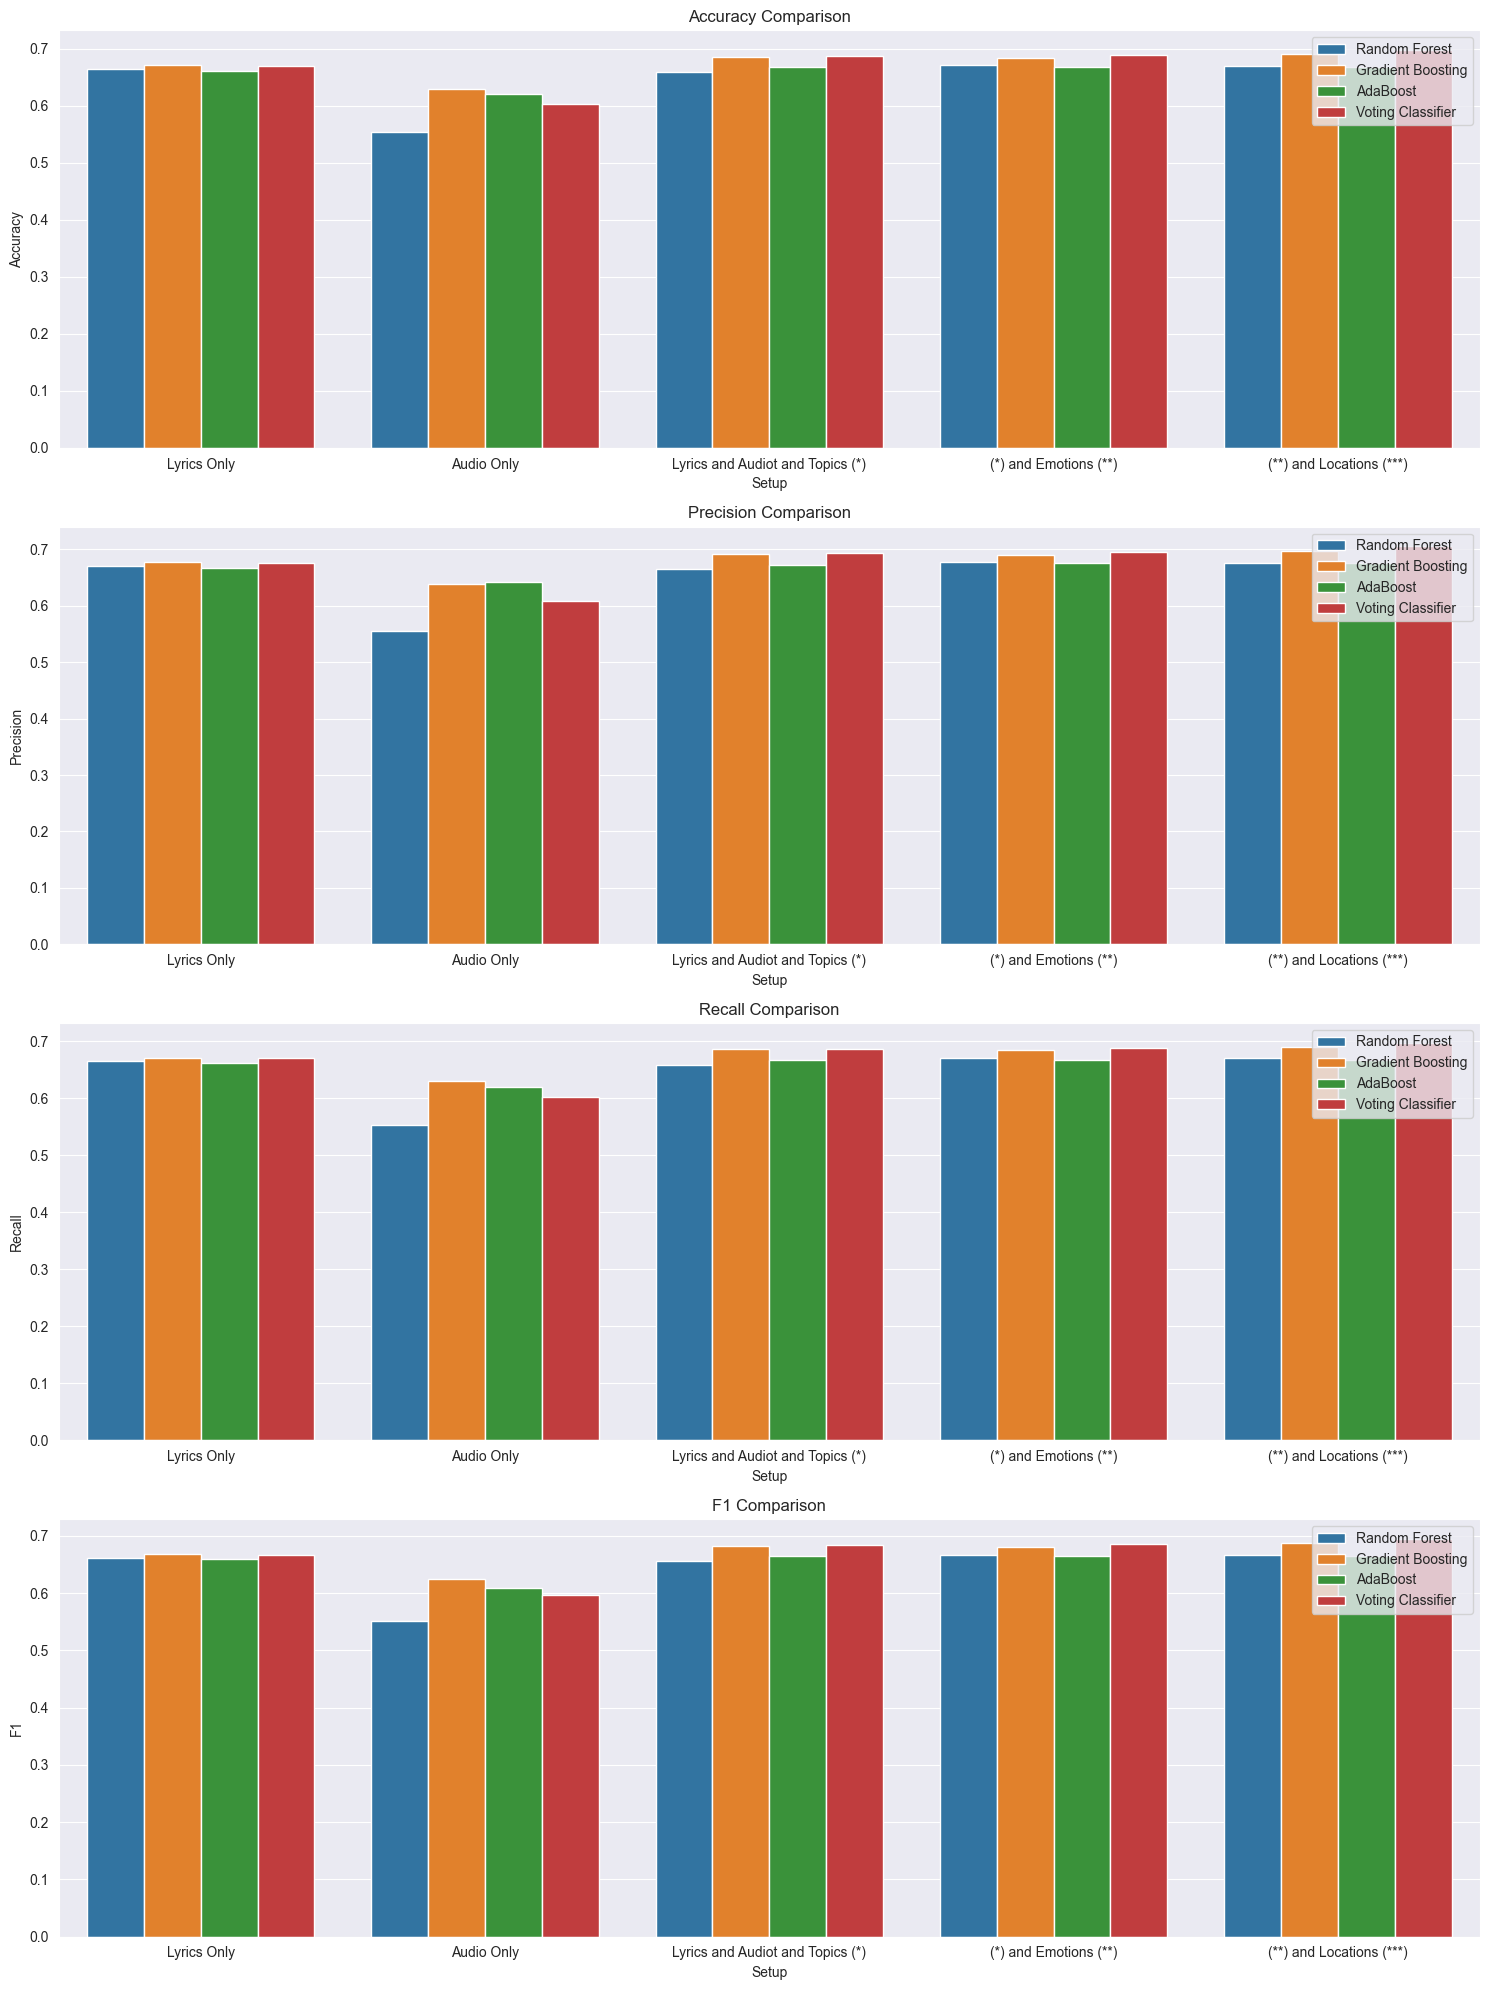

In [212]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def plot_metrics(all_metrics):
    # Prepare data for plotting
    setups = list(all_metrics.keys())
    metrics = ['accuracy', 'precision', 'recall', 'f1']
    classifiers = list(all_metrics[setups[0]]['accuracy'].keys())

    # Initialize subplots
    fig, axes = plt.subplots(len(metrics), 1, figsize=(15, 20))

    for i, metric in enumerate(metrics):
        data = []
        for setup in setups:
            for clf in classifiers:
                mean_score = np.mean(all_metrics[setup][metric][clf])
                data.append([setup, clf, mean_score])

        df_plot = pd.DataFrame(data, columns=['Setup', 'Classifier', metric.capitalize()])

        sns.barplot(x='Setup', y=metric.capitalize(), hue='Classifier', data=df_plot, ax=axes[i])
        axes[i].set_title(f'{metric.capitalize()} Comparison')
        axes[i].legend(loc='upper right')

    plt.tight_layout()
    plt.show()

# Plot the metrics
plot_metrics(all_metrics)

In [218]:
def plot_voting_classifier_metrics(all_metrics):
    # Prepare data for plotting
    setups = list(all_metrics.keys())
    metrics = ['accuracy', 'precision', 'recall', 'f1']
    classifier = 'Voting Classifier'

    data = []
    for setup in setups:
        for metric in metrics:
            mean_score = np.mean(all_metrics[setup][metric][classifier])
            data.append([setup, metric, mean_score])

    df_plot = pd.DataFrame(data, columns=['Setup', 'Metric', 'Mean Score'])

    # Create the line plot
    plt.figure(figsize=(12, 8))
    sns.lineplot(x='Setup', y='Mean Score', hue='Metric', data=df_plot, marker='o')

    plt.title('Voting Classifier Metrics Across Different Setups')
    plt.ylabel('Mean Score')
    plt.xlabel('Setup')
    plt.legend(title='Metric', loc='upper left', bbox_to_anchor=(1, 1))
    plt.tight_layout()
    plt.savefig('Voting_classifier_metrics')
    plt.show()

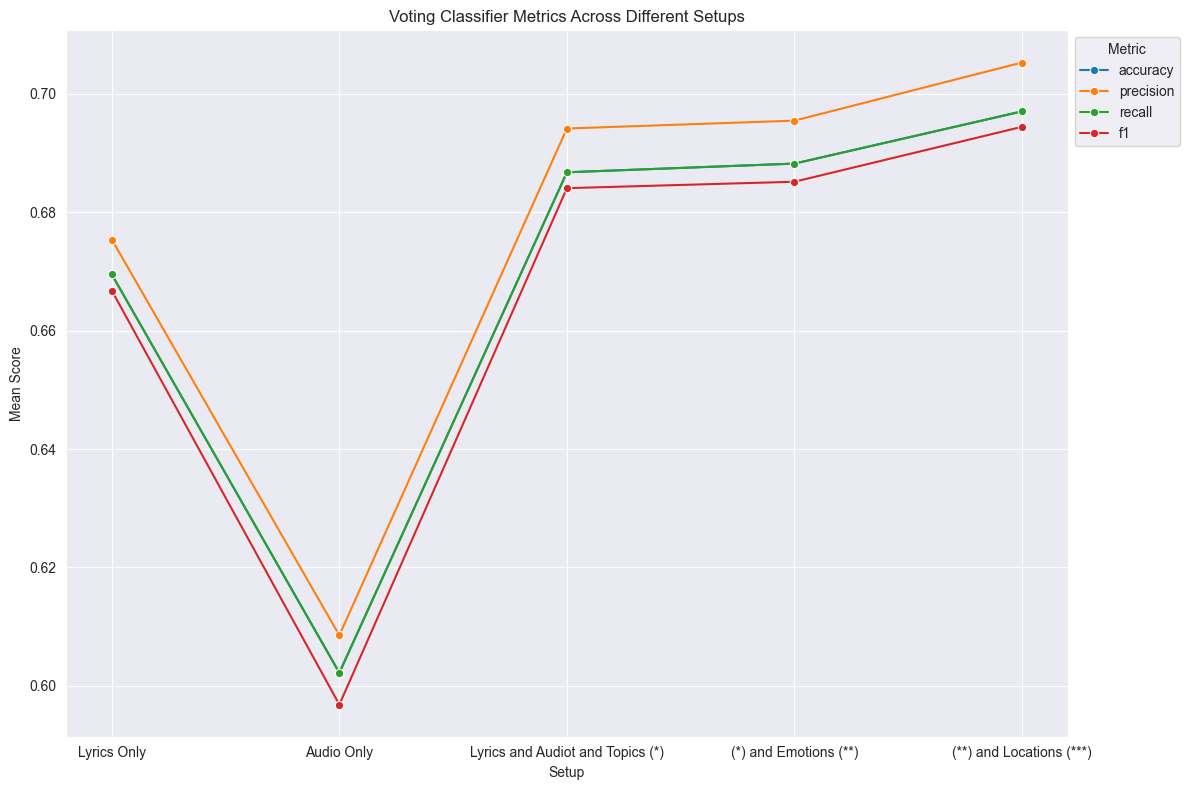

In [219]:
plot_voting_classifier_metrics(all_metrics)